In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL/Homework

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/AN2DL/Homework


In [18]:
from functools import partial, reduce
from pathlib import Path

import numpy as np
import tensorflow as tf
import tensorflow.data as tfd
from tensorflow.data import Dataset as tfds
from keras_cv.layers import GridMask, RandomChannelShift, RandomHue, RandomZoom, RandomSharpness
from keras.layers import RandomRotation, RandomTranslation, Layer
import keras_cv


from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2

In [4]:
SEED = 42
DATA_DIR = Path().absolute() / "dataset"
DATA_PATH = DATA_DIR / "training_set.npz"
OUTPUT_DIR = DATA_DIR / "augmented"

In [5]:
RNG = np.random.default_rng(SEED)

In [6]:
with np.load(DATA_PATH) as data:
    images: np.ndarray = data["images"]
    labels: np.ndarray = data["labels"]

print(images.shape)
print(labels.shape)

(13759, 96, 96, 3)
(13759, 1)


## Cleaning

In [7]:
image_means: np.ndarray = images.mean(axis=(1, 2, 3))

In [8]:
TOLERANCE = 1e-4
MIN_DUPLICATES = 5

mean_indices = {}
for mean in image_means:
    indices = (np.abs(mean - image_means) <= TOLERANCE).nonzero()[0]
    if len(indices) > MIN_DUPLICATES:
        mean_indices[mean] = indices

len(mean_indices.keys())

2

In [9]:
duplicated_indices = []
for indices in mean_indices.values():
    duplicated_indices.extend(indices)
duplicated_indices = np.array(duplicated_indices)
duplicated_indices.shape

(1800,)

In [10]:
original_indices = np.setdiff1d(
    list(range(images.shape[0])),
    duplicated_indices
)
original_indices.shape

(11959,)

In [43]:
clean_images = images[original_indices]
clean_labels = labels[original_indices]

print(clean_images.shape)
print(clean_labels.shape)

(11959, 96, 96, 3)
(11959, 1)


## Background removal and replacement with noise

In [48]:
hue_min_deg, hue_max_deg = 180, 360
sat_min_perc, sat_max_perc = 22, 100
val_min_perc, val_max_perc = 20, 70

hue_min = int(hue_min_deg / 2)
hue_max = int(hue_max_deg / 2)
sat_min = int(sat_min_perc * 255 / 100)
sat_max = int(sat_max_perc * 255 / 100)
val_min = int(val_min_perc * 255 / 100)
val_max = int(val_max_perc * 255 / 100)

no_bg_images = []

for sample in clean_images:
  hsv_img = cv2.cvtColor(sample, cv2.COLOR_RGB2HSV)
  mask = cv2.inRange(hsv_img, (hue_min, sat_min, val_min), (hue_max, sat_max, val_max))
  masked_img = cv2.bitwise_and(sample, sample, mask=mask)


  gray = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)

  _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)


  kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
  dilated_mask = cv2.dilate(binary_mask, kernel, iterations=2)

  contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    convex_hull = cv2.convexHull(largest_contour)
  else:
    convex_hull = None

  mask = np.zeros_like(dilated_mask)
  if convex_hull is not None:
    cv2.drawContours(mask, [convex_hull], -1, (255), thickness=cv2.FILLED)

  bb_image = cv2.bitwise_and(sample, sample, mask=mask)

  black_mask = np.all(bb_image == [0, 0, 0], axis=-1)

  noise = np.random.randint(0, 256, bb_image.shape, dtype=np.uint8)
  no_bg_img = bb_image.copy()
  no_bg_img[black_mask] = noise[black_mask]

  no_bg_images.append(no_bg_img)

clean_images = np.asarray(no_bg_images)

# Rebalance


In [49]:
unique_labels, counts = np.unique(clean_labels, return_counts=True)
count_proportion = counts / counts.max()
sample_proportion = 1 / count_proportion
sample_proportion

array([2.73474178, 1.06831729, 2.14746544, 1.15004936, 2.74440518,
       2.34642497, 1.        , 1.41813755])

In [50]:
rebalanced_image_list = []
rebalanced_label_list = []
for label, count, proportion in zip(np.unique(clean_labels), counts, sample_proportion):
    label_support = np.nonzero(clean_labels == label)[0]
    i = RNG.choice(label_support, int(np.round(count * proportion)))
    rebalanced_image_list.append(clean_images[i])
    rebalanced_label_list.append(clean_labels[i])

In [51]:
rebalanced_images = np.concatenate(rebalanced_image_list, axis=0)
rebalanced_labels = np.concatenate(rebalanced_label_list, axis=0)

print(rebalanced_images.shape)
print(rebalanced_labels.shape)

(18640, 96, 96, 3)
(18640, 1)


## Validation split

In [52]:
images_train, images_val, labels_train, labels_val = train_test_split(
    rebalanced_images, rebalanced_labels,
    test_size=.15,
    random_state=42,
    stratify=rebalanced_labels,
)

print(images_train.shape)
print(labels_train.shape)

print(images_val.shape)
print(labels_val.shape)

(15844, 96, 96, 3)
(15844, 1)
(2796, 96, 96, 3)
(2796, 1)


## Augmentation

In [54]:
train_dataset = tfds.from_tensor_slices((images_train, labels_train))
val_dataset = tfds.from_tensor_slices((images_val, labels_val))

In [55]:
def augment(dataset: tf.data.Dataset) -> tf.data.Dataset:
    AUGMENTATIONS = [
        keras_cv.layers.RandomTranslation((0.3, 0.4), (0.3, 0.4), fill_mode="nearest"),
        keras_cv.layers.RandomRotation(1.0, fill_mode="nearest"),
        keras_cv.layers.RandomChannelShift(value_range=(0, 255), factor=(0.3, 0.5)),
        keras_cv.layers.RandomBrightness((-0.4, -0.3)),
        keras_cv.layers.RandomZoom(height_factor=(-0.5, 0.5), width_factor=(-0.5, 0.5), fill_mode="nearest"),
        RandomSharpness(factor=(0.0, 0.5), value_range=(0, 255))
    ]

    def augmentation_function(x, y):
        augmentations_dict = {
            i: partial(augmentation, x) for i, augmentation in enumerate(AUGMENTATIONS)
        }
        i = tf.random.uniform([], maxval=len(augmentations_dict), dtype=tf.int32)
        augmented_x = tf.cast(tf.switch_case(i, augmentations_dict), tf.uint8)
        return augmented_x, y

    return dataset.map(augmentation_function, num_parallel_calls=tf.data.AUTOTUNE)

In [56]:
def one_hot_encode(x, y, num_classes=8):
    return (
        x,
        tf.reshape(
            tf.cast(to_categorical(y, num_classes=num_classes), tf.uint8),
            [-1],
        )
    )

In [59]:
augmented_train_dataset = (
    augment(train_dataset)
    .concatenate(train_dataset)
    .map(one_hot_encode, num_parallel_calls=tf.data.AUTOTUNE)
)
augmented_train_dataset = augmented_train_dataset.shuffle(augmented_train_dataset.cardinality())
augmented_train_dataset.save(str(OUTPUT_DIR / "train"))

augmented_val_dataset = (
    augment(val_dataset)
    .concatenate(val_dataset)
    .map(one_hot_encode, num_parallel_calls=tf.data.AUTOTUNE)
)
augmented_val_dataset = augmented_val_dataset.shuffle(augmented_val_dataset.cardinality())
augmented_val_dataset.save(str(OUTPUT_DIR / "val"))

## Analysis

In [60]:
augmented_train_dataset = tf.data.Dataset.load(str(OUTPUT_DIR / "train"))
augmented_val_dataset = tf.data.Dataset.load(str(OUTPUT_DIR / "val"))

In [61]:
augmented_train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(8,), dtype=tf.uint8, name=None))>

In [62]:
len([sample for sample in augmented_train_dataset])

31688

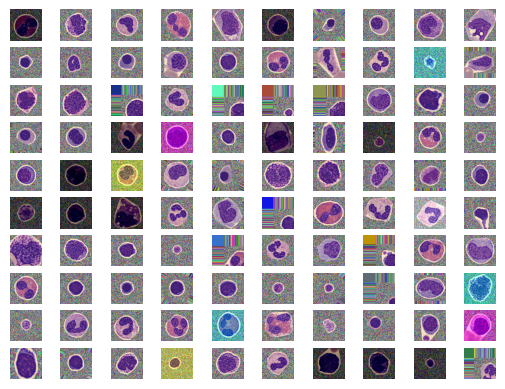

In [63]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.reshape((-1))

for ax, (image, _) in zip(axes, augmented_train_dataset.as_numpy_iterator()):
    ax.set_axis_off()
    ax.imshow(image)